In [1]:
%pip install -q --upgrade pip
%pip install -q \
  diffusers==0.31.0 \
  transformers==4.47.1 \
  accelerate==0.34.2 \
  peft==0.12.0 \
  datasets>=2.19,<3.0 \
  safetensors>=0.4.5 \
  einops>=0.7.0 \
  packaging>=24.0


USE_XFORMERS = False
try:
    import xformers
    USE_XFORMERS = True
except Exception:
    try:
        %pip install -q xformers
        import xformers
        USE_XFORMERS = True
    except Exception:
        USE_XFORMERS = False

import torch, platform
print({
    "torch": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "device_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu",
    "python": platform.python_version(),
    "xformers": USE_XFORMERS
})


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.1 MB/s eta 0:00:00
/bin/bash: line 1: 3.0: No such file or directory
{'torch': '2.9.0+cu126', 'cuda_available': True, 'device_name': 'Tesla T4', 'python': '3.12.12', 'xformers': True}


In [2]:
try:
    import google.colab  # type: ignore
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted.")
except Exception:
    print("Not in Colab or Drive mount skipped.")


Mounted at /content/drive
Drive mounted.


The cell below is needed to be used in case when dataset is downloaded from the folder

In [3]:
%pip -q install gdown
from pathlib import Path
import json, re, os

FOLDER_URL = "https://drive.google.com/drive/folders/1BZfBSTL0-qIvyw7zdtHmxL-VhXnkeLhw?usp=sharing"
OUT = Path("/content/dataset")
OUT.mkdir(parents=True, exist_ok=True)

import gdown
gdown.download_folder(
    FOLDER_URL,
    output=str(OUT),
    quiet=False,
    use_cookies=True,
    remaining_ok=True
)

exts = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff"}
kept = []
seen_hash = set()

import hashlib
for p in list(OUT.rglob("*")):
    if p.is_dir():
        continue
    if p.suffix.lower() not in exts:
        p.unlink(missing_ok=True)
        continue
    with open(p, "rb") as f:
        h = hashlib.md5(f.read(1<<20)).hexdigest()
    if h in seen_hash:
        p.unlink(missing_ok=True)
        continue
    seen_hash.add(h)
    kept.append(p)

print("Number of images:", len(kept))
if len(kept) == 0:
    raise RuntimeError("There are no images.")

meta = OUT / "metadata.jsonl"
if not meta.exists():
    def to_caption(p: Path):
        stem = re.sub(r"[_\\-]+", " ", p.stem).strip()
        return f"photo of {stem}" if stem else "photo"
    with open(meta, "w", encoding="utf-8") as f:
        for p in kept:
            f.write(json.dumps({
                "file_name": str(p.relative_to(OUT)),
                "text": to_caption(p)
            }, ensure_ascii=False) + "\n")
    print("Generated:", meta)
else:
    print("Found:", meta)


Retrieving folder contents


Processing file 1KkrYcecstfQoM0Mg75yPsKIYrClHQf1G 0a5d237477199c0ebbc3d2ea75179333.jpg
Processing file 1Qs2db8nOSX6hJ5UaTo91Oy84CQqGSHTB 0f4b9da4f715b8476d3e4fd8cec07097.jpg
Processing file 1UiANCO-YpqxDb0bMUCXptbHlRZ0C4xpg 2bf1573c63777723442107a7cacf8a13.jpg
Processing file 1lYosCAgC0m083XQH86yxYQ9nXIGssckQ 2da6ba2ade9e86444a89a16c9fd9cb4f.jpg
Processing file 19EJmhbQFuRZ-XAkOxLMMQaU45rtITc8P 2fcaba4982a9115e02bc008475132b79.jpg
Processing file 1GAc3buAnVflWoHTXLZTnMYvhhEdT1kve 3f8f109a67be0a116733d98ce30eb040.jpg
Processing file 1U6Zz89KRmwdg9b3lRMEFosRj_qlvrDam 4e4347489e411396189a611b05645ae2.jpg
Processing file 1PgjGI6wYNZSqsaZmoyLMEIjTS-4QaYa0 8a7f514ff164a93839b11de09a052eb6.jpg
Processing file 1egSsxYw6rwU5wZknuSAUfmn0c4LsxTd2 9af9448eee7cce0f949dcaea74508e30.jpg
Processing file 1C9bvYq4ORowjwYQo4leJbLjB1ssZWT1o 25e45a268e0544040954e7fc539ddf55.jpg
Processing file 1Udo9TQU_UaGYaIm6XFGdpfgskG_pACx2 32f6ca603f286090a5716109218c9679.jpg
Processing file 1yuTgftrfakK52C_oNdMsBYHkv_

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1KkrYcecstfQoM0Mg75yPsKIYrClHQf1G
To: /content/dataset/0a5d237477199c0ebbc3d2ea75179333.jpg
100%|██████████| 579k/579k [00:00<00:00, 6.90MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qs2db8nOSX6hJ5UaTo91Oy84CQqGSHTB
To: /content/dataset/0f4b9da4f715b8476d3e4fd8cec07097.jpg
100%|██████████| 55.3k/55.3k [00:00<00:00, 7.93MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UiANCO-YpqxDb0bMUCXptbHlRZ0C4xpg
To: /content/dataset/2bf1573c63777723442107a7cacf8a13.jpg
100%|██████████| 96.1k/96.1k [00:00<00:00, 3.30MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lYosCAgC0m083XQH86yxYQ9nXIGssckQ
To: /content/dataset/2da6ba2ade9e86444a89a16c9fd9cb4f.jpg
100%|██████████| 63.4k/63.4k [00:00<00:00, 2.51MB/s]
Downloading...
From: https://drive.google.com/uc?id=19EJmhbQFuRZ-XAkOxLMMQaU45rtITc8P
To: /content/dataset/2f

Number of images: 29
Generated: /content/dataset/metadata.jsonl



Download completed


The cell below is needed to be used in case when dataset is downloaded from zip file

In [4]:
ZIP_SRC = "https://drive.google.com/file/d/1az2B3qNZ1VTa6m3VW-3PyhlbVkosgALC/view?usp=sharing"

from pathlib import Path
import os, re, json, zipfile

# Download files
def maybe_download_zip(src: str, out_path: Path) -> Path:
    if src.startswith("http") or (len(src) > 20 and "/" not in src):  # URL or file-id
        try:
            import gdown
        except ImportError:
            import sys, subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
            import gdown
        out_path.parent.mkdir(parents=True, exist_ok=True)
        gdown.download(src, str(out_path), quiet=False, fuzzy=True)
        return out_path
    return Path(src)

ZIP_PATH = maybe_download_zip(ZIP_SRC, Path("/content/dataset.zip"))

ROOT = Path("/content/dataset")
if ROOT.exists():
    try: (ROOT / "metadata.jsonl").unlink()
    except FileNotFoundError: pass
else:
    ROOT.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(ROOT)

IMG_DIR = ROOT / "images"
CAP_DIR = ROOT / "captions"
assert IMG_DIR.exists(), f"There is no folder {IMG_DIR}"
assert CAP_DIR.exists(), f"There is no folder {CAP_DIR}"

IMG_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff"}
META = ROOT / "metadata.jsonl"
REQUIRE_ALL_CAPTIONS = True

def fallback_caption(stem: str) -> str:
    s = re.sub(r"[_\\-]+", " ", stem).strip()
    return s or "photo"

images = sorted([p for p in IMG_DIR.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS])
if not images:
    raise RuntimeError(f"There is no pictures {IMG_DIR}")

written, missing = 0, []
with open(META, "w", encoding="utf-8") as f:
    for img in images:
        cap = CAP_DIR / f"{img.stem}.txt"
        if cap.exists():
            text = cap.read_text(encoding="utf-8").strip() or fallback_caption(img.stem)
        else:
            if REQUIRE_ALL_CAPTIONS:
                missing.append(img.name); continue
            text = fallback_caption(img.stem)
        rel = "images/" + str(img.relative_to(IMG_DIR)).replace("\\", "/")
        f.write(json.dumps({"file_name": rel, "text": text}, ensure_ascii=False) + "\n")
        written += 1

if missing:
    raise RuntimeError(f"There are no captions: {len(missing)} number. Examples: {missing[:5]}")

print(f"OK: {written} records → {META}")


Downloading...
From: https://drive.google.com/uc?id=1az2B3qNZ1VTa6m3VW-3PyhlbVkosgALC
To: /content/dataset.zip
100%|██████████| 4.92M/4.92M [00:00<00:00, 28.2MB/s]


OK: 49 records → /content/dataset/metadata.jsonl


In [12]:
from pathlib import Path

PRETRAINED = "Manojb/stable-diffusion-2-1-base"
DATA_DIR   = Path("/content/dataset")
OUTPUT_DIR = Path("/content/lora_out")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

train_cfg = {
    "pretrained_model_name_or_path": PRETRAINED,
    "train_data_dir": str(DATA_DIR),
    "caption_column": "text",
    "image_column": "image",
    "resolution": 448,
    "center_crop": True,
    "random_flip": True,

    "train_batch_size": 2,
    "gradient_accumulation_steps": 2,
    "gradient_checkpointing": True,
    "max_train_steps": 200,
    "learning_rate": 5e-4,
    "lr_scheduler": "cosine",
    "lr_warmup_steps": 20,

    "rank": 16,
    "lora_alpha": 16,
    "lora_dropout": 0.05,
    "train_text_encoder": True,

    "output_dir": str(OUTPUT_DIR),
    "validation_prompt": "photo of pastel postcard with roses, soft bokeh, postcard, no text",
    "num_validation_images": 2,
    "validation_epochs": 1,
    "checkpointing_steps": 500,
    "seed": 42,
}


In [13]:
import os, urllib.request, pathlib

SCRIPT_URL = "https://raw.githubusercontent.com/huggingface/diffusers/v0.31.0/examples/text_to_image/train_text_to_image_lora.py"
LOCAL_SCRIPT = "/content/train_text_to_image_lora.py"
pathlib.Path("/content").mkdir(parents=True, exist_ok=True)
urllib.request.urlretrieve(SCRIPT_URL, LOCAL_SCRIPT)
print("Saved:", LOCAL_SCRIPT, "size:", os.path.getsize(LOCAL_SCRIPT))


Saved: /content/train_text_to_image_lora.py size: 40692


In [14]:
import subprocess, sys

def build_cmd_fixed(cfg: dict, use_xformers: bool):
    cmd = [
        sys.executable, "-m", "accelerate.commands.launch",
        "--mixed_precision=no",
        "--num_processes=1", "--num_machines=1", "--gpu_ids=0",
        "/content/train_text_to_image_lora.py",
        "--pretrained_model_name_or_path", cfg["pretrained_model_name_or_path"],
        "--train_data_dir", cfg["train_data_dir"],
        "--caption_column", cfg["caption_column"],
        "--image_column",   cfg["image_column"],
        "--resolution", "448",
        "--train_batch_size", "2",
        "--gradient_accumulation_steps", "2",
        "--learning_rate", "5e-4",
        "--max_train_steps", "200",
        "--lr_scheduler", "cosine",
        "--lr_warmup_steps", "20",
        "--rank", "16",
        "--output_dir", cfg["output_dir"],
        "--allow_tf32",
        "--dataloader_num_workers", "2",
        "--center_crop", "--random_flip",
        "--gradient_checkpointing",
        # --validation_prompt/--num_validation_images/--validation_epochs
        # --checkpointing_steps
    ]
    if use_xformers:
        cmd.append("--enable_xformers_memory_efficient_attention")
    return cmd


USE_XFORMERS = False
cmd = build_cmd_fixed(train_cfg, USE_XFORMERS)
print("RUN:", " ".join(cmd))


RUN: /usr/bin/python3 -m accelerate.commands.launch --mixed_precision=no --num_processes=1 --num_machines=1 --gpu_ids=0 /content/train_text_to_image_lora.py --pretrained_model_name_or_path Manojb/stable-diffusion-2-1-base --train_data_dir /content/dataset --caption_column text --image_column image --resolution 448 --train_batch_size 2 --gradient_accumulation_steps 2 --learning_rate 5e-4 --max_train_steps 200 --lr_scheduler cosine --lr_warmup_steps 20 --rank 16 --output_dir /content/lora_out --allow_tf32 --dataloader_num_workers 2 --center_crop --random_flip --gradient_checkpointing


In [15]:
p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
for line in p.stdout: print(line, end="")
p.wait(); print("RC:", p.returncode)


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-11-24 21:43:18.811612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764020598.830649    4312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764020598.836472    4312 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764020598.853338    4312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:176402

In [16]:
!ls -lh /content/lora_out


total 13M
drwxr-xr-x 3 root root 4.0K Nov 24 21:46 logs
-rw-r--r-- 1 root root  13M Nov 24 21:57 pytorch_lora_weights.safetensors


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/28 [00:00<?, ?it/s]

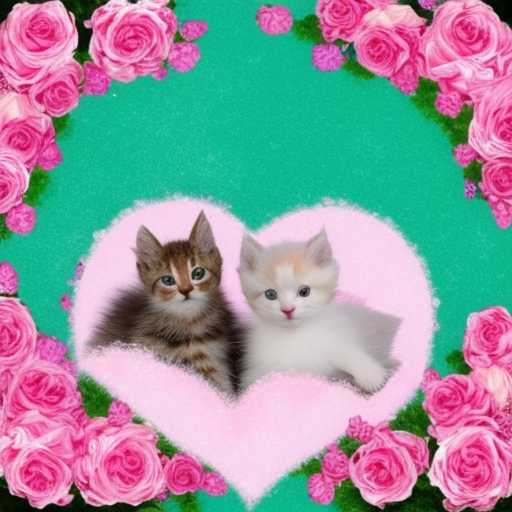

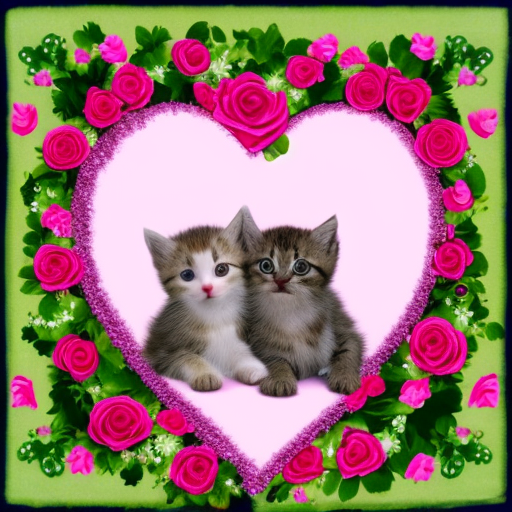

In [17]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import display

BASE = "Manojb/stable-diffusion-2-1-base"
LORA_DIR = "/content/lora_out"
WT_NAME  = "pytorch_lora_weights.safetensors"

pipe = StableDiffusionPipeline.from_pretrained(
    BASE, torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights(LORA_DIR, weight_name=WT_NAME)

prompt = "picture of two kittens sitting inside a big pink heart, sparkles and roses, pastel background, no text"
images = pipe(
    prompt,
    num_inference_steps=28,
    guidance_scale=7.0,
    cross_attention_kwargs={"scale": 0.8},
    num_images_per_prompt=2,
).images

for i, img in enumerate(images):
    display(img)
    img.save(f"/content/sample_{i}.png")

